**Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

In [102]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from scipy.sparse import hstack
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
# from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
import string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import pickle

In [4]:
#importing the training data
data=pd.read_csv('IMDB Dataset.csv')
print(data.shape)
data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
#Summary of the dataset
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


**Sentiment count**

In [6]:
#Class Distrubution
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

We can see that the dataset is perfectly balanced.

### Change Target variable

In [7]:
## 0 as Negative and 1 as Positive
data.sentiment=data.sentiment.apply(lambda x: 0 if x=='negative' else 1)

#### Let's start with feature extraction.
<a id = 3></a>
<h1><font color = MidnightBlue>Feature Engineering</font></h1>
<hr style="width:100%;height:1.2px;border-width:0;background-color:silver">

### Indirect features:

- count of sentences
- count of words
- count of unique words
- -count of letters
- count of punctuations
- count of uppercase words/letters
- count of stop words
- Avg length of each word

In [8]:
## Indirect features
eng_stopwords = set(stopwords.words("english"))

data['count_sent']=data["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
data['count_word']=data["review"].apply(lambda x: len(str(x).split()))
#Unique word count
data['count_unique_word']=data["review"].apply(lambda x: len(set(str(x).split())))
#Letter count
data['count_letters']=data["review"].apply(lambda x: len(str(x)))
#punctuation count
data["count_punctuations"] =data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
data["mean_word_len"] = data["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#Word count percent in each comment:
data['word_unique_percent']=data['count_unique_word']*100/data['count_word']
#Punct percent in each comment:
data['punct_percent']=data['count_punctuations']*100/data['count_word']
#derived features
#Word count percent in each comment:
data['word_unique_percent']=data['count_unique_word']*100/data['count_word']
#derived features
#Punct percent in each comment:
data['punct_percent']=data['count_punctuations']*100/data['count_word']

In [9]:
## Reordering the columns 
data = data[['review', 'count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent','sentiment']]
data.head()

,review,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,sentiment
0,One of the other reviewers has mentioned that ...,1,307,208,1761,78,8,36,133,4.739414,67.752443,25.407166,1
1,A wonderful little production. <br /><br />The...,1,162,114,998,44,2,12,66,5.166667,70.370370,27.160494,1
2,I thought this was a wonderful way to spend ti...,1,166,121,926,40,3,20,76,4.584337,72.891566,24.096386,1
3,Basically there's a family where a little boy ...,1,138,96,748,42,3,13,62,4.427536,69.565217,30.434783,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,152,1317,56,1,31,96,4.730435,66.086957,24.347826,1


### Visualization- Understand your data better

#### 1) Understanding Sentiment across Word count
- This visualization shows us that count of words in positive and negative reviews have same pattern

Text(0.5, 1.0, 'Distribution of Words in review across Target var')

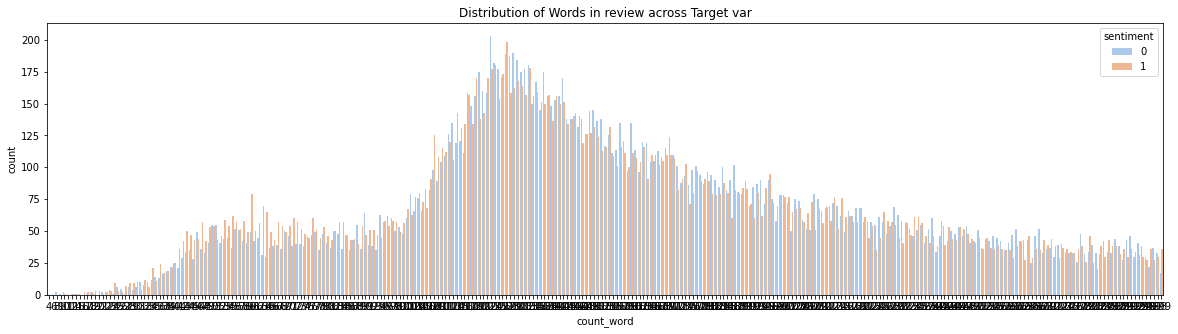

In [10]:

plt.figure(figsize=(20, 5))
data1=data[data.count_word<300]
ax = sns.countplot(x="count_word",  hue='sentiment', data=data1, palette="pastel")
plt.title("Distribution of Words in review across Target var")

#### 2) Understanding Sentiment across Punctuation count
- This shows usage of punctuations is same in both sentiments. This negate general perception of higher usage of punctuation in negative reviews

Text(0.5, 1.0, 'Distribution of Punctuations in review across review sentiment')

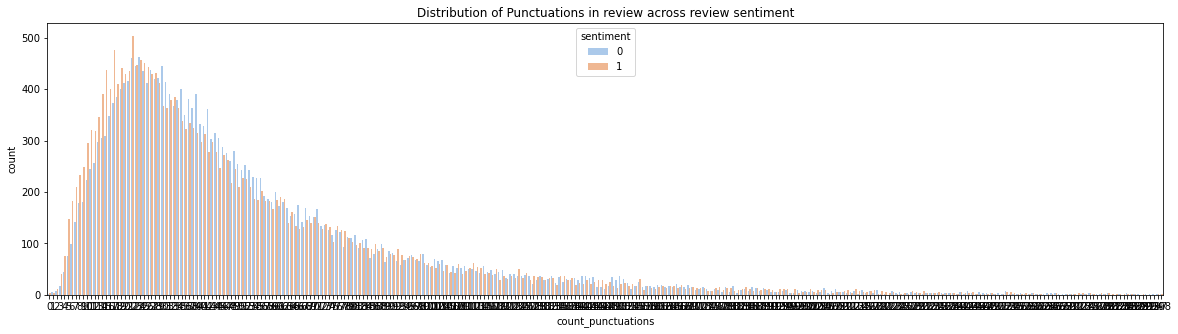

In [11]:

plt.figure(figsize=(20, 5))
data1=data[data.count_punctuations<300]
ax = sns.countplot(x="count_punctuations",  hue='sentiment', data=data1, palette="pastel")
plt.title("Distribution of Punctuations in review across review sentiment")

#### 2) Understanding Sentiment across Stopwords count
- This graph don't highlight any specific feature across classes.

Text(0.5, 1.0, 'Distribution of Stopwords in review across review sentiment')

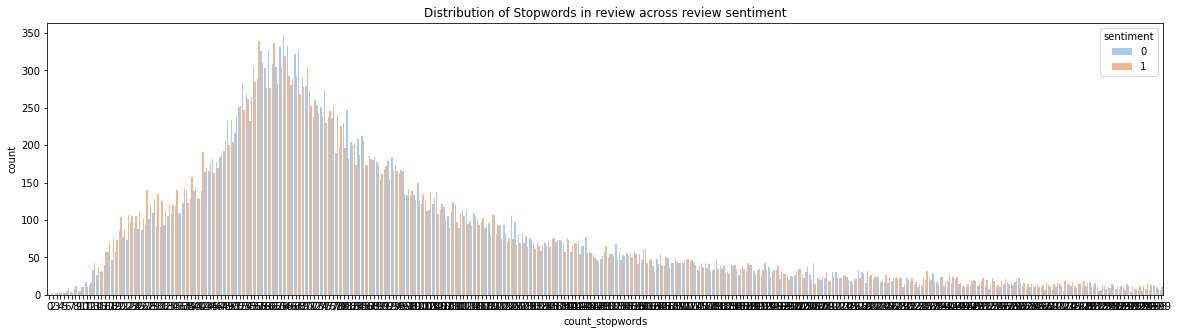

In [12]:

plt.figure(figsize=(20, 5))
data1=data[data.count_stopwords<300]
ax = sns.countplot(x="count_stopwords",  hue='sentiment', data=data1, palette="pastel")
plt.title("Distribution of Stopwords in review across review sentiment")

#### 4) Mean values on Indirect features

In [13]:
data.groupby(['sentiment'],as_index=False).mean()

,sentiment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0,1.0,229.46456,152.2662,1294.06436,53.59836,5.14632,24.72780,103.38132,4.623461,70.896372,23.447622
1,1,1.0,232.84932,152.0156,1324.79768,51.55876,4.56928,27.96804,104.31900,4.657892,70.164729,22.077985


- This shows mean value of each indirect feature is almost similar for both the sentiments. No startling differences were observed for any feature. This also indicate that model comprising these indirect features as explanatory variable will not yield good accuracy score. So to get good classification model, we have to develop machine learning or neural network model based on word vectorizer only.

#### 5) Histogram for word count for both classes

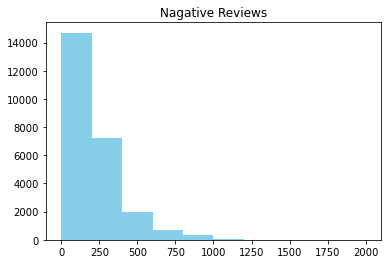

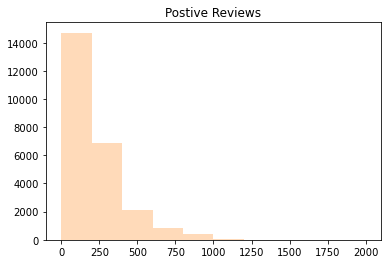

In [14]:
plt.hist(data[data['sentiment']==0]['count_word'],range=(0,2000),color='SkyBlue')
plt.title('Nagative Reviews')
plt.show()

plt.hist(data[data['sentiment']==1]['count_word'],range=(0,2000),color='PeachPuff')
plt.title('Postive Reviews')
plt.show()


## Text Preprocessing of Reviews

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# Removing all punctuations from Text
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def word_replace(text):
    return text.replace('<br />','')


from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])



from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])



def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def preprocess(text):
    text=clean_contractions(text,mapping)
    text=text.lower()
    text=word_replace(text)
    text=remove_urls(text)
    text=remove_html(text)
    text=remove_stopwords(text)
    text=remove_punctuation(text)
#     text=stem_words(text) ## Takes too much of time
    text=lemmatize_words(text)
    
    return text


<b> In machine learning task, cleaning or pre-processing the data is as important as model building if not more. And when it comes to unstructured data like text, this process is of most importance. IMDB reviews are posted by users manually, so we observe high usage of contractions and chat words in it. Also, we also observe usage of many HTML tags in dataset.</b>

**a. Clean Contractions or Chat Words:**
As this is manually entered reviews, people do use a lot of abbreviated words in chat and so it is important for us to expand all such chat words and contractions used. I’ve used list of slangs and contractions from repo.

**b. Lower Casing** Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way. This is more helpful for text featurization techniques like frequency, tfidf as it helps to combine the same words together thereby reducing the duplication and get correct counts / tfidf values.

**c. Removal Of Stop Words**
Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis. These stopword lists are already compiled for different languages and we can safely use them. For example, the stopword list for english language is,

**d. Stemming** Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form. For example, if there are two words in the corpus walks and walking, then stemming will stem the suffix to make them walk. In some cases, stemming results in shorting the world literals and we lose information in it. So Lemmatization is better process.

**e. Lemmatization**
Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language. As a result, this one is generally slower than stemming process. I’m using standard WordNetLemmatizer for work.

**f. Removal Of Emojis & Emoticons** With more and more usage of social media platforms, there is an explosion in the usage of emojis in our day to day life as well. As IMDB reviews are manually added, we found usage of Emojis & Emoticons, so we removed them.

**g. Removal Of Urls & HTML Tags:**
We found large usage of HTML tags in dataset. To make sense of dataset, such tags to be removed.

**h. Removal Of Punctuations** In this process, we remove the punctuations (!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~) from the text data. This is a text standardization process that will help to treat 'hurray' and 'hurray!' in the same way. Note of caution- This process has to be performed after removal of HTML tags else some standard tags of HTML will partially get removed in this process and afterwards HTML removal process will not give suitable results.

In [17]:
data["reviews_p"] = data["review"].apply(lambda text: preprocess(text))
data.head()

,review,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,sentiment,reviews_p
0,One of the other reviewers has mentioned that ...,1,307,208,1761,78,8,36,133,4.739414,67.752443,25.407166,1,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,1,162,114,998,44,2,12,66,5.166667,70.370370,27.160494,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,166,121,926,40,3,20,76,4.584337,72.891566,24.096386,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,1,138,96,748,42,3,13,62,4.427536,69.565217,30.434783,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,152,1317,56,1,31,96,4.730435,66.086957,24.347826,1,petter matteis love time money visually stunni...


# Word Cloud

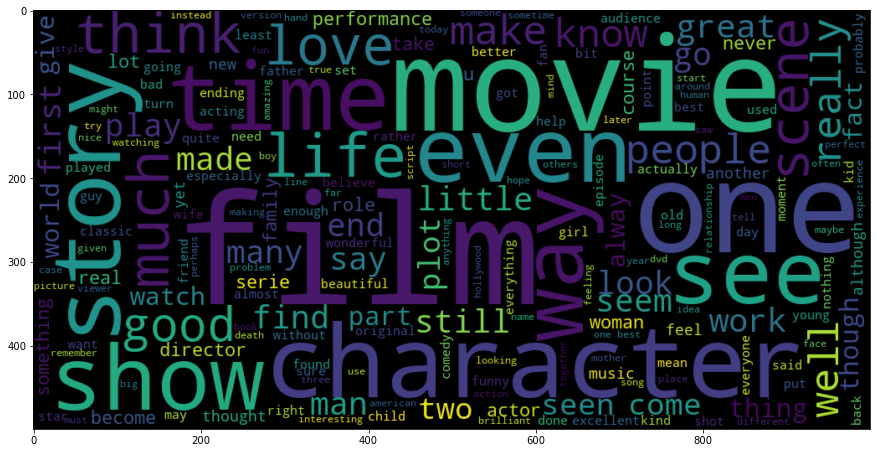

In [18]:
#Positive reviews
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 200 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.sentiment == 1].reviews_p))
plt.imshow(wc , interpolation = 'bilinear')

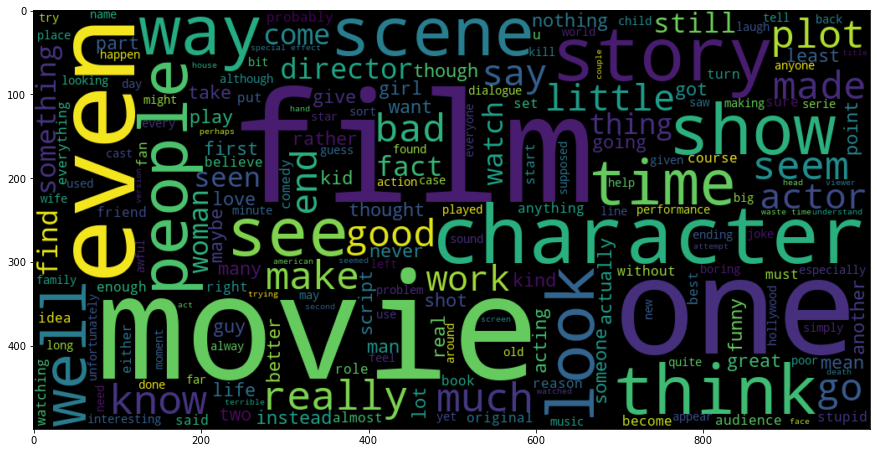

In [19]:
# Negative Reviews.
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 200 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.sentiment == 0].reviews_p))
plt.imshow(wc , interpolation = 'bilinear')

- From these word clouds, we are not able to judge any startling differences in both the sentiments by looking at words. We don’t see usage of extreme negative connotation or abusive language used while writing negative reviews.

### Utility Function

In [20]:
def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)
    
    

# Model based on Indirect Features

In [21]:
X=data[['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']]
y=data['sentiment']

- Selecting numerical features for training model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [23]:
[i.shape for i in [X_train, X_test, y_train, y_test] ]

[(40000, 11), (10000, 11), (40000,), (10000,)]

C:\Users\eleme\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


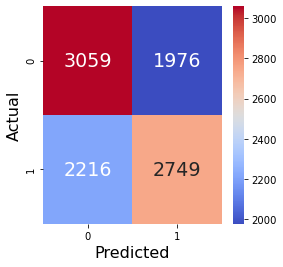


Accuracy:  0.58

F1 Score:  0.57

Report:               precision    recall  f1-score   support

           0       0.58      0.61      0.59      5035
           1       0.58      0.55      0.57      4965

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



In [24]:
# Logistic Regression with Indirect features
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(X_train, y_train)
metrics(classifier,X_test,y_test)

- As expected, this model is giving us poor accuracy of 58% as we depicted in EDA. Indirect features have very similar trends and patterns across both the classes, we have seen in EDA portion.

## Unsupervised- Pre-trained model- TextBlob 
- TextBlob is a python library for Natural Language Processing (NLP). TextBlob actively used Natural Language ToolKit (NLTK) to achieve tasks related to sentiment analysis. NLTK is a library which gives an easy access to a lot of lexical resources and allows users to work with categorization, classification and many other tasks. TextBlob is a simple library which supports complex analysis and operations on textual data. For lexicon-based approaches, a sentiment is defined by its semantic orientation and the intensity of each word in the sentence. This requires a pre-defined dictionary classifying negative and positive words. Generally, a text message will be represented by bag of words. After assigning individual scores to all the words, final sentiment is calculated by some pooling operation like taking an average of all the sentiments.

In [25]:
from textblob import TextBlob

In [26]:
def get_sentiment( tweet):
        analysis = TextBlob(tweet)
      
        if analysis.sentiment.polarity > 0:
            return 'positive'
        else:
            return 'negative'

In [27]:
data['TextBlob']=data['reviews_p'].apply(lambda x: get_sentiment(x))

In [28]:
print(data.TextBlob.value_counts())
print("\n",data.sentiment.value_counts())

positive    36959
negative    13041
Name: TextBlob, dtype: int64

 1    25000
0    25000
Name: sentiment, dtype: int64


In [29]:
data['TextBlob1']=data.TextBlob.apply(lambda x: 0 if x=='negative' else 1)

In [30]:
accuracy_score(data.sentiment,data.TextBlob1)

0.69598

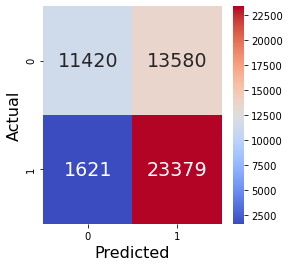

In [31]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(data.sentiment,data.TextBlob1),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()


- This model gives us accuracy of 69%. This model is not able to perform the best way possible as negative reviews contain any negative words. We know, after assigning individual scores to all the words, final sentiment is calculated by some pooling operation like taking an average of all the sentiments

## N-gram Analysis
- The order that words are used in text is not random. In English, for example, you can say "the red apple" but not "apple red the". The general idea is that you can look at each pair (or double, triple etc.) of words that occur next to each other. In a sufficently-large corpus, you're likely to see "the red" and "red apple" several times, but less likely to see "apple red" and "red the". This is useful to know if, for example, you're trying to figure out what someone is more likely to say to help decide between possible output for an automatic speech recognition system. These co-occuring words are known as "n-grams", where "n" is a number saying how long a string of words you considered.

In [32]:
texts = ' '.join(data['reviews_p'])

In [33]:
string = texts.split(" ")

In [34]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:7]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (10,5))
    return sns.barplot(x='count',y='word', data=n_gram_df)

<a id = 11></a>
<h2><font color = MidnightBlue>Unigram Analysis</font></h2>

       word  count
0  (movie,)  98938
1   (film,)  89753
2    (one,)  52648
3   (like,)  39780
4  (would,)  30291


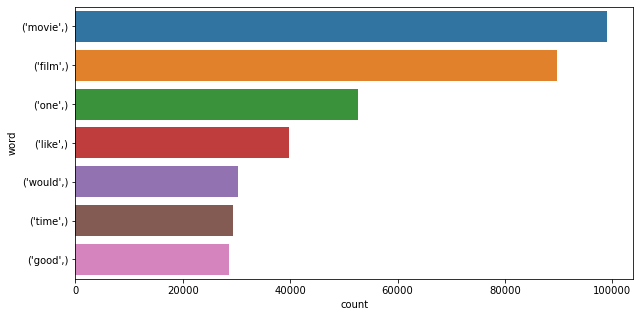

In [35]:
draw_n_gram(string,1)

<a id = 12></a>
<h2><font color = MidnightBlue>Bigram Analysis</font></h2>

                word  count
0       (look, like)   2874
1       (ever, seen)   2534
2  (special, effect)   2198
3      (movie, ever)   1937
4  (main, character)   1875


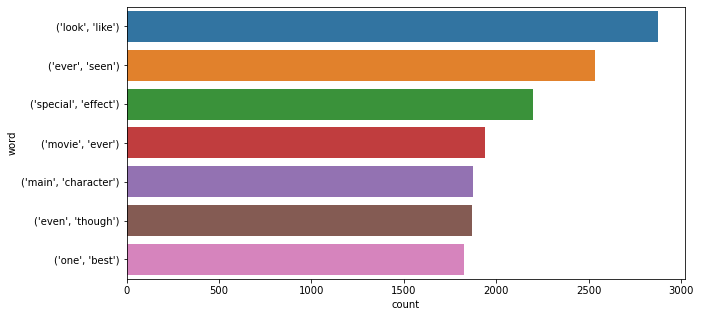

In [36]:
draw_n_gram(string,2)

<a id = 13></a>
<h2><font color = MidnightBlue>Trigram Analysis</font></h2>

                   word  count
0   (movie, ever, seen)    828
1  (worst, movie, ever)    731
2    (film, ever, seen)    413
3   (worst, film, ever)    344
4   (movie, ever, made)    337


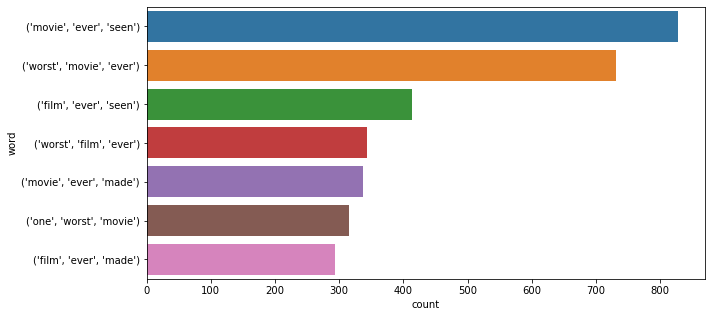

In [37]:
draw_n_gram(string,3)

This N
gram analysis showcase words which are
occurring together in IMDB data base.
From Uni
gram we see that ‘Movie’ word occurs more
than 1L times in dataset, which is quite obvious.
From Bi
gram, we see that ‘look like’ and ‘ever seen’
words have occurred more than 2500 times together
From Tri
gram, we see that ‘movie ever seen ’ has
observed maximum number of times together.

# Word Embedding: 
- Many Machine Learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw form. They require numbers as inputs to perform any sort of job, be it classification, regression etc. in broad terms. A Word Embedding format generally tries to map a word using a dictionary to a vector.

## Frequency Based Vectorization

In [114]:
X_train, X_test, y_train, y_test = train_test_split(data['reviews_p'], data['sentiment'], test_size=0.2,random_state=0)

In [115]:
[i.shape for i in [X_train, X_test, y_train, y_test] ]

[(40000,), (10000,), (40000,), (10000,)]

### **1) TF-IDF-** 
- In TF-IDF which based on the frequency method but it is different to the count vectorization in the sense that it takes into account not just the occurrence of a word in a single document but in the entire corpus. Common words like ‘is’, ‘the’, ‘a’ etc. tend to appear quite frequently in comparison to the words which are important to a document. Ideally, what we would want is to down weight the common words occurring in almost all documents and give more importance to words that appear in a subset of documents. TF-IDF works by penalising these common words by assigning them lower weights while giving importance to words like Messi in a particular document.

In [106]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=10000
)

vect= word_vectorizer.fit(data['reviews_p'])

tfidf_train = word_vectorizer.transform(X_train)
tfidf_test = word_vectorizer.transform(X_test)

In [107]:
with open('word_vectorizer.pk','wb') as fin:
    pickle.dump(vect, fin)

In [111]:
file=open('word_vectorizer.pk','rb')
vect=pickle.load(file)

In [118]:
testing='it was a good movie'
testing=[testing]
testing1=vect.transform(testing)

In [41]:
# word_vectorizer.get_feature_names()

In [42]:
print('Shape of tfidf_train:',tfidf_train.shape)
print('Shape of tfidf_test:',tfidf_test.shape)

Shape of tfidf_train: (40000, 10000)
Shape of tfidf_test: (10000, 10000)


### **2) Count Vectorizer-** 
- It is tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. CountVectorizer creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is nothing but the count of the word in that particular text sample.

In [43]:
cv=CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}',ngram_range=(1,3),max_features=10000)
cv.fit(data['reviews_p'])
cv_train=cv.transform(X_train)
cv_test=cv.transform(X_test)

In [44]:
print('Shape of cv_train:',cv_train.shape)
print('Shape of cv_test:',cv_test.shape)

Shape of cv_train: (40000, 10000)
Shape of cv_test: (10000, 10000)


## Machine Learning Models

## 1) Logistic Regression

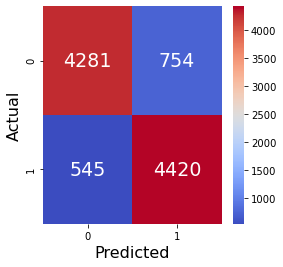


Accuracy:  0.87

F1 Score:  0.87

Report:               precision    recall  f1-score   support

           0       0.89      0.85      0.87      5035
           1       0.85      0.89      0.87      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [45]:
# Logistic Regression with TF-IDF
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(tfidf_train, y_train)
metrics(classifier,tfidf_test,y_test)

C:\Users\eleme\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


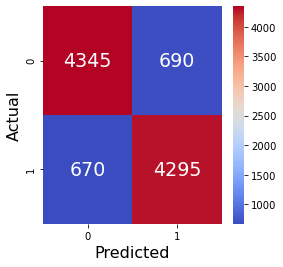


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.87      0.86      0.86      5035
           1       0.86      0.87      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [46]:
# Logistic Regression with Count Vectoriser
classifier1 = LogisticRegression(penalty='l2',C=10)
classifier1.fit(cv_train, y_train)

metrics(classifier1,cv_test,y_test)

## 2) Naive Bayes

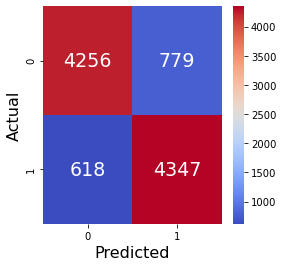


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.87      0.85      0.86      5035
           1       0.85      0.88      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [47]:
#Naive Bayes with tf_idf
model= MultinomialNB()

model.fit(tfidf_train, y_train)
metrics(model,tfidf_test,y_test)

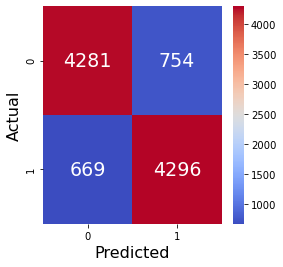


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.86      0.85      0.86      5035
           1       0.85      0.87      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [48]:
#Naive Bayes with Count Vectorizer
modela= MultinomialNB()

modela.fit(cv_train, y_train)
metrics(modela,cv_test,y_test)

### 3) XGBoost

In [49]:
model = XGBClassifier() #Default XGBoost Model with TF_IDF
model.fit(tfidf_train, y_train)

C:\Users\eleme\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:10:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

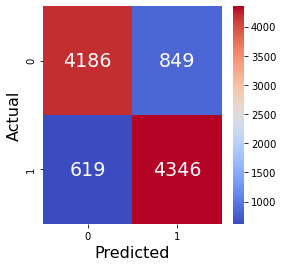


Accuracy:  0.85

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.87      0.83      0.85      5035
           1       0.84      0.88      0.86      4965

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [50]:
metrics(model,tfidf_test,y_test)

In [51]:
modelcv = XGBClassifier() #Default XGBoost Model with count Vectorizer
modelcv.fit(cv_train, y_train)

[11:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

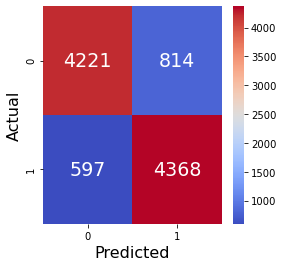


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.88      0.84      0.86      5035
           1       0.84      0.88      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [52]:
metrics(modelcv,cv_test,y_test)

### 4) SVM

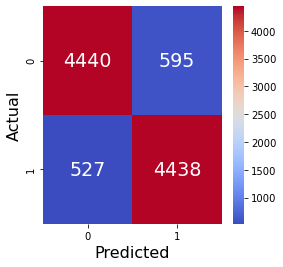


Accuracy:  0.89

F1 Score:  0.89

Report:               precision    recall  f1-score   support

           0       0.89      0.88      0.89      5035
           1       0.88      0.89      0.89      4965

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [116]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(penalty='l2')
linear_svc.fit(tfidf_train, y_train)
metrics(linear_svc,tfidf_test,y_test)

In [120]:
with open('svm.pk','wb') as fin:
    pickle.dump(linear_svc, fin)

In [122]:
file=open('svm.pk','rb')
l=pickle.load(file)

In [123]:
l.predict(testing1)

array([1], dtype=int64)

C:\Users\eleme\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


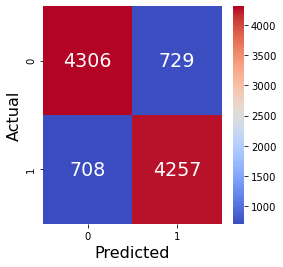


Accuracy:  0.86

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.86      0.86      0.86      5035
           1       0.85      0.86      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [54]:
#on Count Vectorizer
linear_svc1 = LinearSVC(C=0.5, random_state=42)
linear_svc1.fit(cv_train, y_train)

metrics(linear_svc1,cv_test,y_test)

## Neural Network Models

In [55]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

In [56]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [57]:
## Out of 50k dataset, 36k for training, 4k for Validationa and 10k for testing

X_train, X_test, y_train, y_test = train_test_split(data['reviews_p'], data['sentiment'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

In [58]:
[x.shape for x in [X_train,X_valid,X_test]]

[(36000,), (4000,), (10000,)]

In [59]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data.reviews_p)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train1[2])

thought wonderful way spend time hot summer weekend sitting air conditioned theater watching lighthearted comedy plot simplistic dialogue witty character likable even well bread suspected serial killer may disappointed realize match point 2 risk addiction thought proof woody allen still fully control style many u grown lovethis would laughed one woodys comedy year dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young womanthis may crown jewel career wittier devil wear prada interesting superman great comedy go see friend
[363, 158, 71, 9, 26, 356, 105, 3, 1791, 3460, 3404, 4712, 2294, 1654, 15, 134, 2, 140, 363, 130, 731, 790, 2, 1518, 15, 1138, 29, 1936, 9, 2685, 102, 1138, 3, 675, 1, 120, 48, 177, 120, 31, 1327, 105, 29, 3, 38, 2, 19, 127, 521, 4227, 924, 1138, 4198, 3557, 151, 1523, 1263, 440, 1138, 311, 269, 1939, 2267, 193, 3307, 149, 1138, 3532, 5, 144, 1138, 1213, 41, 40, 41, 233, 445, 3606, 2000, 62, 3, 46, 101, 1341, 3472,

In [60]:
print(X_train[2])


thought wonderful way spend time hot summer weekend sitting air conditioned theater watching lighthearted comedy plot simplistic dialogue witty character likable even well bread suspected serial killer may disappointed realize match point 2 risk addiction thought proof woody allen still fully control style many u grown lovethis would laughed one woodys comedy year dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young womanthis may crown jewel career wittier devil wear prada interesting superman great comedy go see friend


In [61]:
seq_lens = [len(s) for s in X_train1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 99.8
max length: 949


In [62]:
maxlen = 150

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

print(X_train1[2, :])

[2147 1562   48   28   53  460  264 2963 1025 4121 1085  187  232  275
 2492   59   35 2104    2  721   88   59 2944  929    7   11   41  161
  815  280    4  139  703  563  508  279  104   27    4   31 3176 2802
 1512  461 1268 1089   36    2   60   17  148   39  219 2087  451  799
  435   58   13  143   80 1138 2554 3460   53    9  851  815  124  241
 2155 4530 2083 1973   26 1151   51 1507    2    3  644 4121 1138  234
 4386   21  630  223  628   84  478  694 1337 3697    1  234  162   19
  134 1138    2   48    5  788  283  302  763 1082  184 2365 4587 1031
  134   16 4146   27  821  120  433   53  561  561   53    3 1654   53
 3167 1290  706    9    2  122 2628  866  134  149  763 1082 1449 2576
  288 3830 2740    2   29   19 1740  548 2406  274]


In [63]:
vocab_size

211094

In [64]:
embedding_dim = 50
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           10554700  
_________________________________________________________________
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                75010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 10,629,721
Trainable params: 10,629,721
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(X_train1, y_train,epochs=10,verbose=True,validation_data=(X_valid1, y_valid),batch_size=1000,callbacks=[callback])

Epoch 1/10
36/36 [==============================] - 7s 116ms/step - loss: 0.6928 - accuracy: 0.5133 - val_loss: 0.6787 - val_accuracy: 0.5462
Epoch 2/10
36/36 [==============================] - 4s 107ms/step - loss: 0.6069 - accuracy: 0.6646 - val_loss: 0.3453 - val_accuracy: 0.8540
Epoch 3/10
36/36 [==============================] - 4s 108ms/step - loss: 0.2872 - accuracy: 0.8880 - val_loss: 0.2892 - val_accuracy: 0.8755
Epoch 4/10
36/36 [==============================] - 4s 108ms/step - loss: 0.2093 - accuracy: 0.9213 - val_loss: 0.2863 - val_accuracy: 0.8792
Epoch 5/10
36/36 [==============================] - 4s 108ms/step - loss: 0.1683 - accuracy: 0.9403 - val_loss: 0.2929 - val_accuracy: 0.8820
Epoch 6/10
36/36 [==============================] - 4s 109ms/step - loss: 0.1330 - accuracy: 0.9614 - val_loss: 0.3067 - val_accuracy: 0.8808


In [66]:
accuracy_score(y_test, model.predict_classes(X_test1))

C:\Users\eleme\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.876

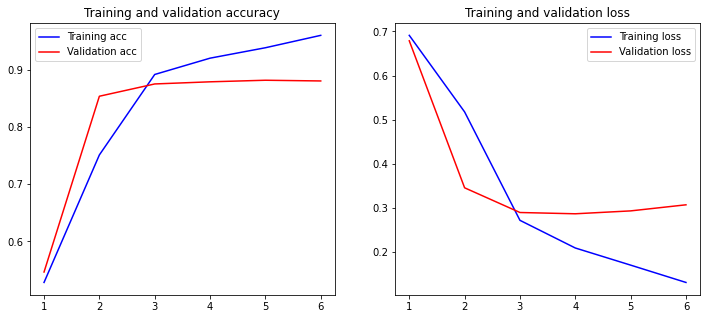

In [67]:
plot_history(history)

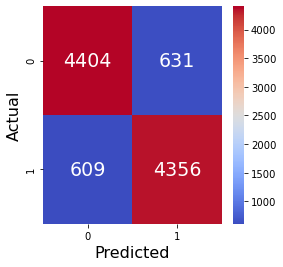

In [68]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, model.predict_classes(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()


In [69]:
X_test1.shape

(10000, 150)

## LSTM Model

In [80]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 50)           10554700  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 10,615,201
Trainable params: 10,615,201
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

Epoch 1/10
141/141 [==============================] - 114s 768ms/step - loss: 0.6658 - accuracy: 0.5554 - val_loss: 0.4826 - val_accuracy: 0.8273
Epoch 2/10
141/141 [==============================] - 126s 895ms/step - loss: 0.3462 - accuracy: 0.8703 - val_loss: 0.2888 - val_accuracy: 0.8832
Epoch 3/10
141/141 [==============================] - 123s 870ms/step - loss: 0.2578 - accuracy: 0.9036 - val_loss: 0.3659 - val_accuracy: 0.8758
Epoch 4/10
141/141 [==============================] - 120s 852ms/step - loss: 0.2362 - accuracy: 0.9134 - val_loss: 0.2942 - val_accuracy: 0.8820


In [86]:
accuracy_score(y_test, model.predict_classes(X_test1))

0.8782

In [83]:
history.history

{'loss': [0.6910785436630249,
  0.517408549785614,
  0.27151551842689514,
  0.20874306559562683,
  0.16988420486450195,
  0.13058523833751678],
 'accuracy': [0.527999997138977,
  0.7512500286102295,
  0.8920833468437195,
  0.9206388592720032,
  0.9388889074325562,
  0.9605833292007446],
 'val_loss': [0.6787241101264954,
  0.3452731668949127,
  0.289237380027771,
  0.2863357663154602,
  0.2928900122642517,
  0.3066924810409546],
 'val_accuracy': [0.5462499856948853,
  0.8539999723434448,
  0.8755000233650208,
  0.8792499899864197,
  0.8820000290870667,
  0.8807500004768372]}

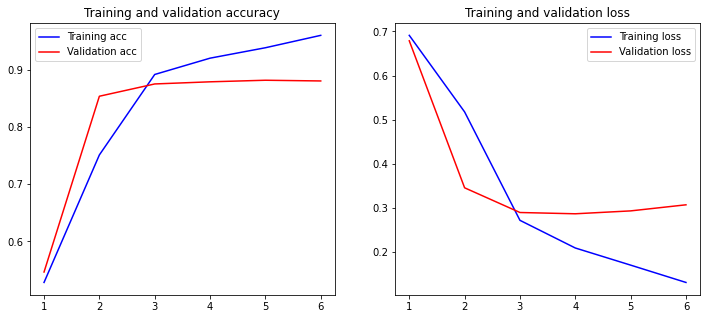

In [84]:
plot_history(history)

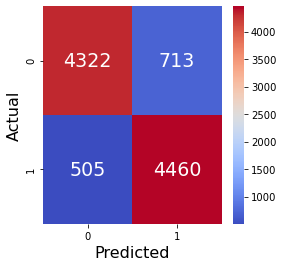

In [85]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, model.predict_classes(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

# CNN Model
https://github.com/mrunal46/Text-Classification-using-LSTM-and-CNN/blob/master/LSTM%20and%20CNN%20on%20imdb.ipynb

In [76]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           10554700  
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 32)           4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 10,612,833
Trainable params: 10,612,833
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

Epoch 1/10
141/141 [==============================] - 53s 346ms/step - loss: 0.6578 - accuracy: 0.5559 - val_loss: 0.3088 - val_accuracy: 0.8692
Epoch 2/10
141/141 [==============================] - 38s 273ms/step - loss: 0.2700 - accuracy: 0.8969 - val_loss: 0.3002 - val_accuracy: 0.8763
Epoch 3/10
141/141 [==============================] - 39s 276ms/step - loss: 0.2064 - accuracy: 0.9250 - val_loss: 0.2857 - val_accuracy: 0.8798
Epoch 4/10
141/141 [==============================] - 41s 289ms/step - loss: 0.1727 - accuracy: 0.9409 - val_loss: 0.2817 - val_accuracy: 0.8802
Epoch 5/10
141/141 [==============================] - 39s 280ms/step - loss: 0.1431 - accuracy: 0.9566 - val_loss: 0.3461 - val_accuracy: 0.8740
Epoch 6/10
141/141 [==============================] - 47s 335ms/step - loss: 0.1065 - accuracy: 0.9686 - val_loss: 0.4350 - val_accuracy: 0.8727


In [78]:
accuracy_score(y_test, model.predict_classes(X_test1))

0.8699

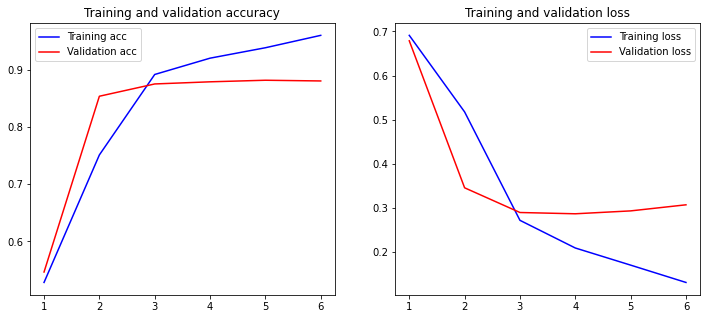

In [79]:
plot_history(history)